In [1]:
import copy
import sre_parse
import sre_constants
from importlib import reload
from dataclasses import asdict
from typing import Tuple

In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import Path as MarkerPath
from matplotlib.transforms import Affine2D
from matplotlib.collections import PatchCollection
import seaborn as sns
from ipywidgets import Accordion, HTML, VBox, HBox, Output, Button, Layout, Dropdown, Tab, Widget, GridBox, Text
from ipywidgets import Label, GridspecLayout
from tqdm import tqdm

In [297]:
import constants
reload(constants)
import solver
reload(solver)

<module 'solver' from '/data/Development/regex_crossword/solver.py'>

In [298]:
def close_all_figures():
    for manager in matplotlib._pylab_helpers.Gcf.get_all_fig_managers():
        plt.close(manager.canvas.figure)
close_all_figures()

%config InlineBackend.close_figures=True 
plt.ion()

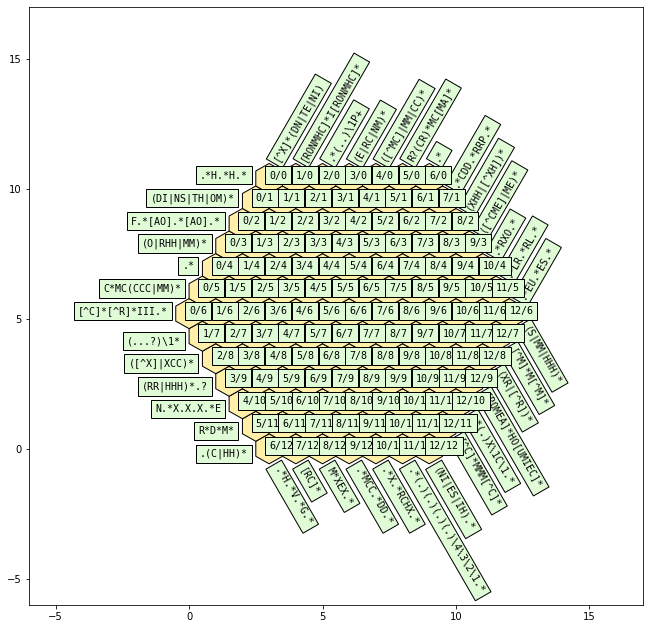

In [299]:
drawer = solver.draw_puzzle(fig_size=11, fontsize=10)

def create_diag_range(i: int) -> Tuple[int, int]:
    start = max(0, i - mid)
    end = min(i + mid + 1, constants.size)
    return start, end

for ii, s in enumerate(constants.x):
    start, end = create_diag_range(ii)
    for jj in range(start, end):
        i = constants.size - jj - 1
        j = ii
        if jj > mid:
            j -= jj - mid
        x, y = drawer.position(i, j)
        drawer.text(x, y, f'{ii}/{jj}')
    
        
if 0:
    for i, s in enumerate(constants.y[::-1]):
        for j in range(solver.row_size(i)):
            x, y = drawer.position(i, j)
            drawer.text(x, y, f'{i}/{j}')

In [300]:
strings = solver.build_strings()
len(strings)

39

In [301]:
strings_df = pd.DataFrame([
    {'axis': s.name[0],
     'name': s.name,
     'pattern': s.pattern.raw,
     'size': s.size}
    for s in strings])
strings_df

,axis,name,pattern,size
0,y,y0,.(C|HH)*,7
1,y,y1,R*D*M*,8
2,y,y2,N.*X.X.X.*E,9
3,y,y3,(RR|HHH)*.?,10
4,y,y4,([^X]|XCC)*,11
5,y,y5,(...?)\1*,12
6,y,y6,[^C]*[^R]*III.*,13
7,y,y7,C*MC(CCC|MM)*,12
8,y,y8,.*,11
9,y,y9,(O|RHH|MM)*,10


In [45]:
def widget_container(container_type, *labeled_children: Tuple[str, Widget]):
    titles, children = zip(*labeled_children)
    accordion = container_type(children)
    for i, t in enumerate(titles):
        accordion.set_title(i, t)
    return accordion

In [46]:
for x in strings[0].gen_possible():
    print(x)

<PMch '.....HH' MatchState(groups=<GBs()>)>
<PMch '....H.H' MatchState(groups=<GBs()>)>
<PMch '....HH.' MatchState(groups=<GBs()>)>
<PMch '...H..H' MatchState(groups=<GBs()>)>
<PMch '...H.H.' MatchState(groups=<GBs()>)>
<PMch '...HH..' MatchState(groups=<GBs()>)>
<PMch '..H...H' MatchState(groups=<GBs()>)>
<PMch '..H..H.' MatchState(groups=<GBs()>)>
<PMch '..H.H..' MatchState(groups=<GBs()>)>
<PMch '..HH...' MatchState(groups=<GBs()>)>
<PMch '.H....H' MatchState(groups=<GBs()>)>
<PMch '.H...H.' MatchState(groups=<GBs()>)>
<PMch '.H..H..' MatchState(groups=<GBs()>)>
<PMch '.H.H...' MatchState(groups=<GBs()>)>
<PMch '.HH....' MatchState(groups=<GBs()>)>
<PMch 'H.....H' MatchState(groups=<GBs()>)>
<PMch 'H....H.' MatchState(groups=<GBs()>)>
<PMch 'H...H..' MatchState(groups=<GBs()>)>
<PMch 'H..H...' MatchState(groups=<GBs()>)>
<PMch 'H.H....' MatchState(groups=<GBs()>)>
<PMch 'HH.....' MatchState(groups=<GBs()>)>


In [47]:
import re
re.match(r'(AB|CD)*\1', 'ABCDCD')

<re.Match object; span=(0, 6), match='ABCDCD'>

In [53]:
widgets = []
with tqdm(strings) as t:
    for s in t:
        ps = list(s.gen_possible())
        output = Output()
        with output:
            display(asdict(s.pattern.re))
            print('Size', s.size)
            print('Span', s.pattern.re.span())
            print('Possible Matches')
            for m in ps:
                print(' ', m.chr_seq)
        widgets.append((f'{s.pattern.raw} sz={s.size} ps={len(ps)}', output))
    
widget_container(Accordion, *widgets)

100%|██████████| 39/39 [00:02<00:00, 17.86it/s]


Accordion(children=(Output(), Output(), Output(), Output(), Output(), Output(), Output(), Output(), Output(), …

In [302]:
%config InlineBackend.close_figures=False 
plt.ioff()
close_all_figures()

widgets = []
with tqdm(pd.Series(strings, dtype=object).sample(15, random_state=0xCAFE)) as t:
    for s in t:
        solution = next(iter(solver.Solution.generate_solutions(s)))
        output = Output()
        with output:
            f = plt.figure(figsize=(14, 14))
            ax = f.add_subplot(111)
            solver.draw_puzzle(ax=ax, fontsize=15, solution=solution)
            display(f)
        widgets.append((f'{s.pattern.raw} sz={s.size} {s.name}', output))
        
widget_container(Accordion, *widgets)

100%|██████████| 15/15 [00:04<00:00,  3.33it/s]


Accordion(children=(Output(), Output(), Output(), Output(), Output(), Output(), Output(), Output(), Output(), …

In [303]:
%config InlineBackend.close_figures=True 
plt.ion()
close_all_figures()

(-4.0, 15.0)

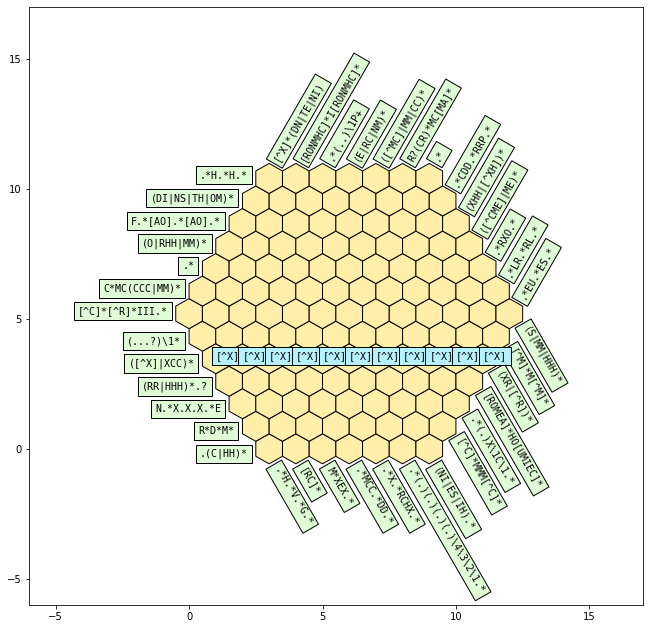

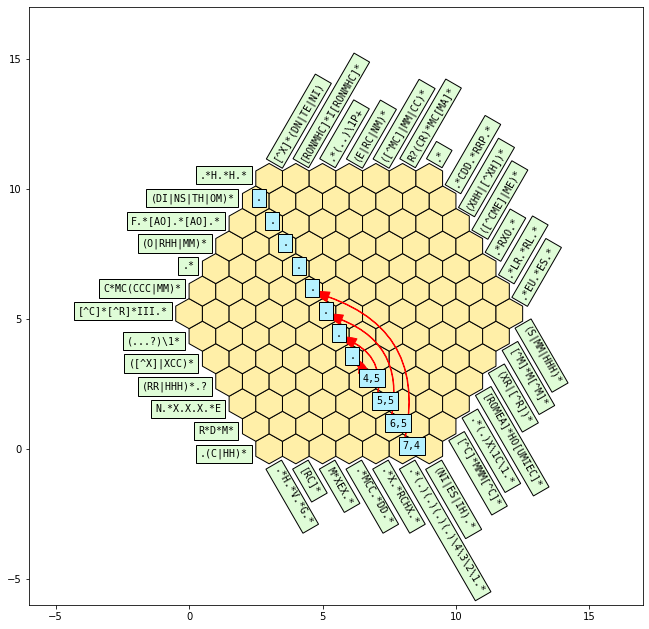

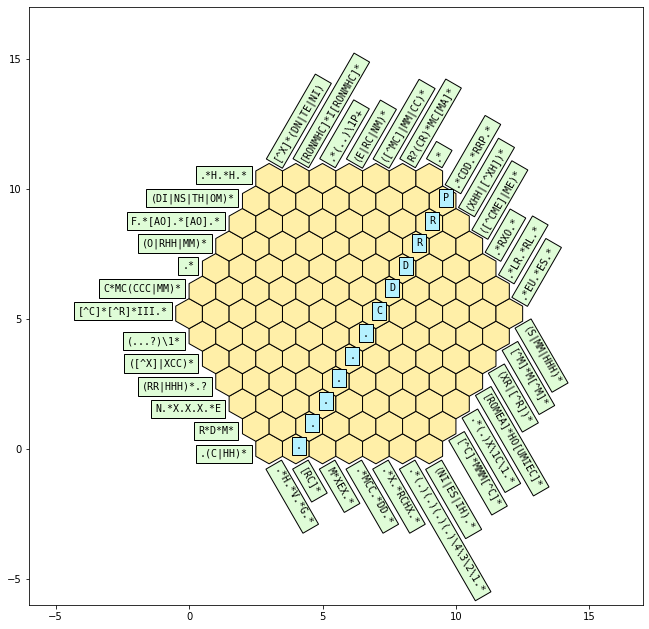

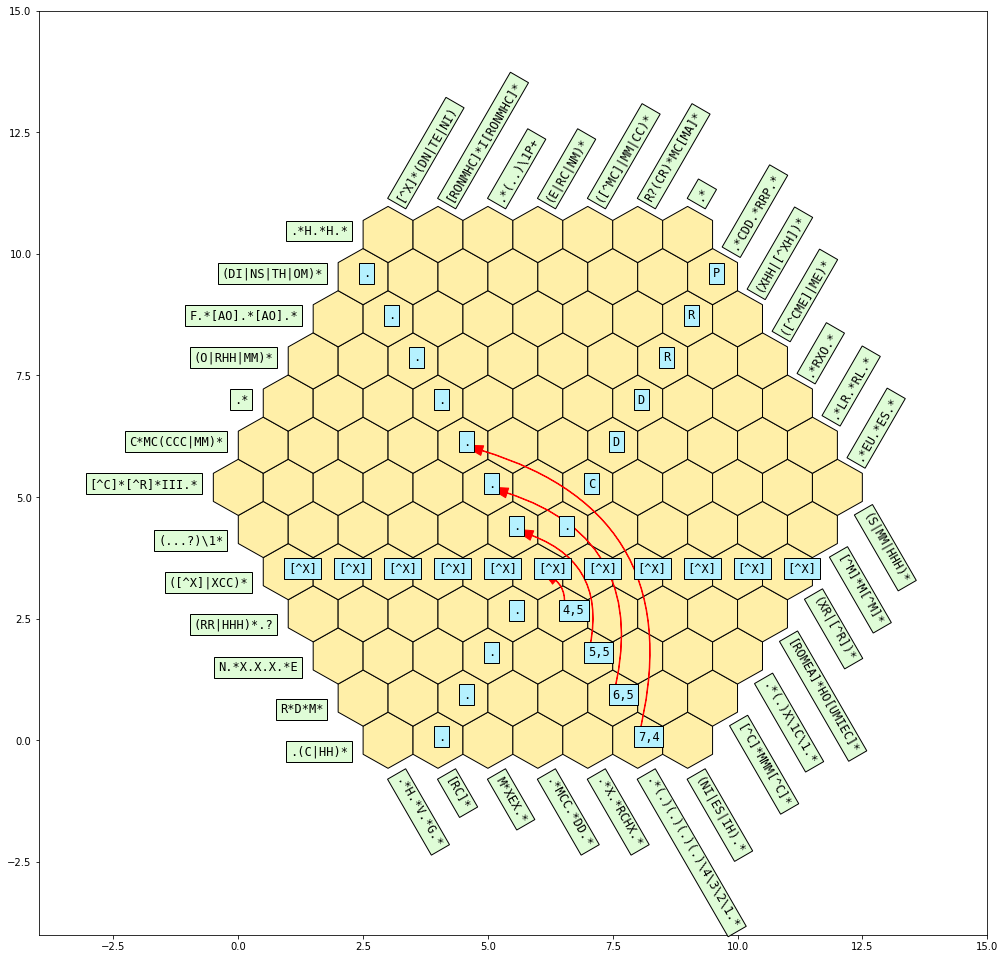

In [265]:
solutions = [next(iter(solver.Solution.generate_solutions(s))) for s in strings]
string_indices = [4, 31, 20]
string_solutions = [solutions[i] for i in string_indices]

for sol in string_solutions:
    solver.draw_puzzle(fig_size=11, fontsize=10, solution=sol)
    
acc = solver.Solution({})
for sol in string_solutions:
    acc = acc.intersection(sol)
    assert acc
        
    
solver.draw_puzzle(fig_size=17, fontsize=12, solution=acc)
plt.xlim(-4, 15)
plt.ylim(-4, 15)

In [308]:
sample_strings_df = (
    strings_df
    .groupby('axis')
    .apply(lambda x: x.reset_index()
           .sample(8, random_state=0xCAFE + ord(x['axis'].iloc[0]))
           .drop('axis', axis=1)
          )
    #.rename(columns={'index': 'org_index'})
    .reset_index()
    .drop('level_1', axis=1)
 )
sample_strings_df

,axis,index,name,pattern,size
0,x,25,x12,.*EU.*ES.*,7
1,x,23,x10,.*RXO.*,9
2,x,19,x6,.*,13
3,x,13,x0,[^X]*(DN|TE|NI),7
4,x,24,x11,.*LR.*RL.*,8
5,x,14,x1,[RONMHC]*I[RONMHC]*,8
6,x,20,x7,.*CDD.*RRP.*,12
7,x,16,x3,(E|RC|NM)*,10
8,y,7,y7,C*MC(CCC|MM)*,12
9,y,1,y1,R*D*M*,8


In [311]:
sample_strings = [strings[i] for i in 
                  sample_strings_df['index'].sample(len(sample_strings_df), random_state=0xCAFE)]
sample_strings

[<St pt='(NI|ES|IH).*' cns=[(12, 0), (11, 1), (10, 2), (9, 3), (8, 4), (7, 5), (6, 6), (5, 6), (4, 6), (3, 6), (2, 6), (1, 6), (0, 6)]>,
 <St pt='.*EU.*ES.*' cns=[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11), (6, 12)]>,
 <St pt='R*D*M*' cns=[(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7)]>,
 <St pt='[^M]*M[^M]*' cns=[(12, 5), (11, 6), (10, 7), (9, 8), (8, 9), (7, 10), (6, 11), (5, 11)]>,
 <St pt='.*RXO.*' cns=[(0, 4), (1, 5), (2, 6), (3, 7), (4, 8), (5, 9), (6, 10), (7, 10), (8, 10)]>,
 <St pt='(E|RC|NM)*' cns=[(3, 0), (4, 1), (5, 2), (6, 3), (7, 3), (8, 3), (9, 3), (10, 3), (11, 3), (12, 3)]>,
 <St pt='[^X]*(DN|TE|NI)' cns=[(6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0)]>,
 <St pt='F.*[AO].*[AO].*' cns=[(10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8)]>,
 <St pt='(...?)\\1*' cns=[(5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11)]>,
 <St pt='.(C|HH)*' cns=[(0, 0), (0, 1), (0, 2)

In [313]:
i = 0

def callback(name, res):
    global i
    i += 1
    if i % 50 == 0:
        print(i, ('no', '  ')[res], 'match', name)

lazy_solutions = solver.merge_many_solutions(
    (solver.SolutionSource(f'{s.name}', solver.Solution.generate_solutions(s))
     for s in sample_strings),
    callback
)
solution = next(iter(lazy_solutions.solutions))

50 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
100 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
150 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
200 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
250 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
300 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
350 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
400 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
450 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
500 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
550 no match 

9150 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
9200    match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
9250 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
9300 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
9350 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
9400 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2
9450 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
9500 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
9550 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
9600 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
9650 no match z6 & x12 & y1 & z11 

22850 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
22900 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
22950 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
23000 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
23050 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
23100 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
23150 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
23200 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
23250 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
23300 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & 

32800 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3
32850 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
32900 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
32950 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
33000 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
33050 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
33100 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
33150 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
33200 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
33250 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
33300 no match z6 

44000 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
44050 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
44100 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
44150 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
44200 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
44250 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
44300 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
44350 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
44400 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
44450 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x

55650 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
55700 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
55750 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
55800 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
55850 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
55900 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
55950 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
56000 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
56050 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
56100 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & 

65800 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
65850 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
65900 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
65950 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
66000 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
66050 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
66100 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
66150 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
66200 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
66250 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x

76950 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
77000 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
77050 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
77100 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
77150 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
77200 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
77250 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
77300 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
77350 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
77400 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 &

89950 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
90000 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
90050 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
90100 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
90150 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
90200 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
90250 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
90300 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
90350 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
90400 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 &

99950 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
100000 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
100050    match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6
100100 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
100150 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
100200 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
100250 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
100300 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
100350 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
100400 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x

112200 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
112250 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
112300 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
112350 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
112400 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3
112450 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
112500    match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
112550 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
112600 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
112650 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
112700 no match z6 

121700 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
121750 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7
121800 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
121850 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
121900 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
121950 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
122000 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
122050 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
122100 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
122150 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
122200 no mat

134500 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
134550 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
134600 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
134650 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
134700 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
134750 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
134800 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
134850 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
134900 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
134950    match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & 

146850 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
146900 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
146950 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
147000 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
147050 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
147100 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
147150 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
147200 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
147250 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
147300    match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 &

156850 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
156900 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
156950 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
157000 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
157050 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
157100 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
157150 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
157200 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
157250 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
157300 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 &

167950 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3
168000 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
168050 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
168100 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
168150 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
168200 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
168250 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
168300 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
168350 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
168400 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6
168450 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 

179350 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
179400 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
179450 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
179500 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
179550 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
179600 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
179650 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
179700 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
179750 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
179800 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 &

190050 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
190100 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
190150 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
190200 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
190250 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
190300 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
190350 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
190400 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
190450 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 & y0 & x7 & z3 & z2 & y8 & y6 & x6 & z12
190500 no match z6 & x12 & y1 & z11 & x10 & x3 & x0 & y10 & y5 &

KeyboardInterrupt: 

In [314]:
with tqdm(strings) as t:
    string_solutions = [list(solver.Solution.generate_solutions(s)) for s in t]

100%|██████████| 39/39 [00:01<00:00, 36.14it/s]


In [320]:
string_solutions_df = pd.Series([len(s) for s in string_solutions],
                                strings_df['name'], name='count').reset_index()
string_solutions_df

,name,count
0,y0,13
1,y1,45
2,y2,3
3,y3,12
4,y4,41
5,y5,2
6,y6,66
7,y7,27
8,y8,1
9,y9,274


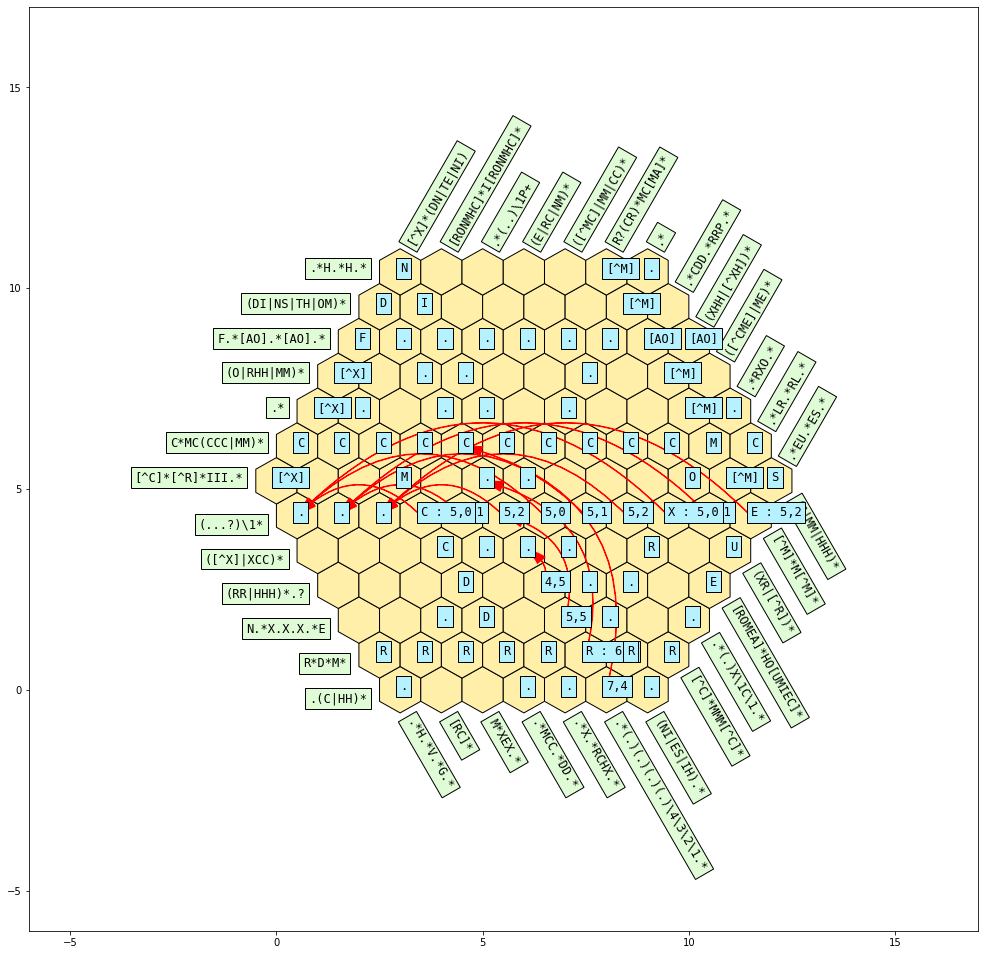

In [307]:
solver.draw_puzzle(fig_size=17, fontsize=12, solution=solution)

In [335]:
string_solutions_df

,name,count
0,y0,13
1,y1,45
2,y2,3
3,y3,12
4,y4,41
5,y5,2
6,y6,66
7,y7,27
8,y8,1
9,y9,274


<AxesSubplot:>

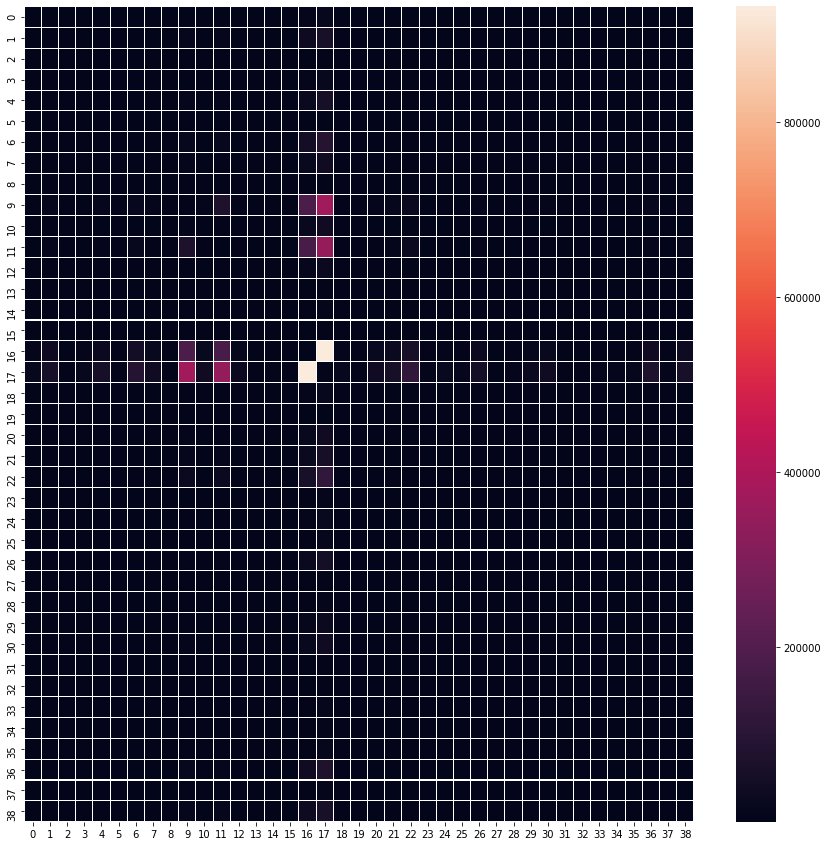

In [334]:
counts = np.array(string_solutions_df['count'])
counts_prod = counts[::, None] * counts[None, ::]
ix = np.arange(len(counts))
counts_prod[ix, ix] = counts
f = plt.figure(figsize=(15, 15))
ax = f.add_subplot(111)
sns.heatmap(counts_prod, linewidth=0.05, ax=ax)

In [351]:
def count_pair_solutions(i, j):
    if i==j:
        return counts[i]
    axis_i = strings_df['axis'].iloc[i]
    axis_j = strings_df['axis'].iloc[j]
    if axis_i == axis_j:
        return counts[i] * counts[j]
    
    lazy_solutions = solver.merge_two_solutions_seq(
        xs=solver.SolutionSource('i', string_solutions[i]),
        ys=solver.SolutionSource('j', string_solutions[j]),
        callback=lambda *args: None
    ).solutions
    return sum(1 for _ in lazy_solutions)

n = len(strings)
count_pair_solutions(5, 9)

548

In [359]:
axis_indexes = {axis:df.index.values for axis,df in strings_df.groupby('axis')}
axis_indexes

{'x': array([13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]),
 'y': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 'z': array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38])}

In [380]:
strings_df['name']

0      y0
1      y1
2      y2
3      y3
4      y4
5      y5
6      y6
7      y7
8      y8
9      y9
10    y10
11    y11
12    y12
13     x0
14     x1
15     x2
16     x3
17     x4
18     x5
19     x6
20     x7
21     x8
22     x9
23    x10
24    x11
25    x12
26     z0
27     z1
28     z2
29     z3
30     z4
31     z5
32     z6
33     z7
34     z8
35     z9
36    z10
37    z11
38    z12
Name: name, dtype: object

In [413]:
def compute_axis_intersection_solutions(axis_a, axis_b):
    sz = constants.size
    indexes_a = axis_indexes[axis_a]
    assert len(indexes_a) == sz
    indexes_b = axis_indexes[axis_b]
    assert len(indexes_b) == sz
    
    data = np.zeros(shape=(sz, sz), dtype=int)
    with tqdm(total=sz**2) as t:
        for i,index_a in enumerate(indexes_a):
            for j,index_b in enumerate(indexes_b):
                t.update()           
                data[i,j] = count_pair_solutions(index_a, index_b)
    return pd.DataFrame(data,
                        index=strings_df['name'].iloc[indexes_a],
                        columns=strings_df['name'].iloc[indexes_b])
    
data = compute_axis_intersection_solutions('y', 'z')

100%|██████████| 169/169 [00:01<00:00, 101.46it/s]


In [414]:
'{:,}'.format(data.max().max())

'9,590'

In [415]:
data.div(data.max().max()).mul(100).astype(int)

name,z0,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12
name,,,,,,,,,,,,,
y0,4,0,0,2,2,0,0,1,0,1,7,1,5
y1,9,0,2,6,7,2,1,4,3,4,25,3,20
y2,0,0,0,0,0,0,0,0,0,0,1,0,1
y3,2,0,0,1,1,0,0,0,0,0,6,1,5
y4,12,0,1,7,7,2,1,2,2,3,20,3,18
y5,0,0,0,0,0,0,0,0,0,0,1,0,0
y6,23,0,4,10,15,3,2,6,4,5,28,5,25
y7,9,0,0,4,5,1,0,1,1,1,6,0,3
y8,0,0,0,0,0,0,0,0,0,0,0,0,0


In [419]:
strings_df.reset_index().set_index('name').loc['y9']

index                9
axis                 y
pattern    (O|RHH|MM)*
size                10
Name: y9, dtype: object

In [420]:
counts[9]

274

<AxesSubplot:xlabel='name', ylabel='name'>

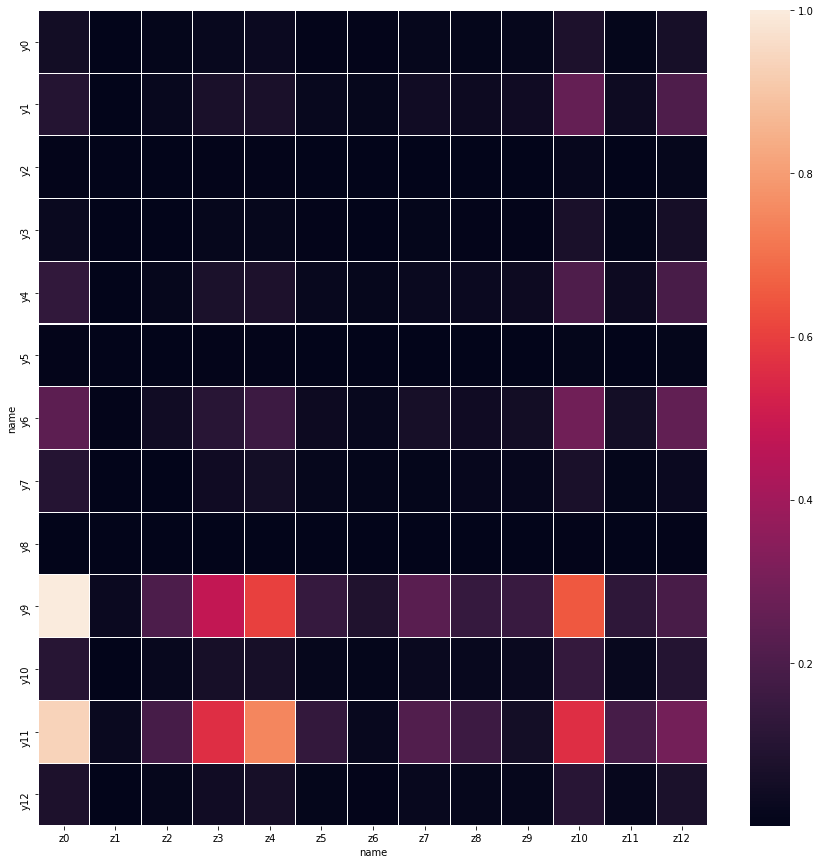

In [418]:
f = plt.figure(figsize=(15, 15))
ax = f.add_subplot(111)
sns.heatmap(data / data.max().max(), linewidth=0.05, ax=ax)

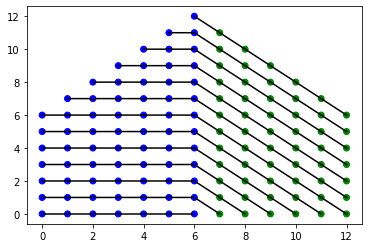

In [59]:
plt.plot()
mid = constants.size // 2
for i, s in enumerate(constants.x):
    points = []
    start = max(0, i-mid)
    end = min(i + mid + 1, constants.size)
    for j in range(start, end):
        x = j
        y = i if j <= mid else mid + i - j
        points.append([x, y, y >= solver.row_size(x),
                       'b' if j <= mid else 'g'])
    x, y, inv, c = map(np.array, zip(*points))
    plt.scatter(x, y, c=c)
    plt.plot(x, y, 'k-')
    if any(inv):
        plt.scatter(x[inv], y[inv], c='r', marker='*', s=200)

    

In [258]:
patterns = pd.DataFrame(
    [{'dim': dim, 'ix':ix, 'pat': pat}
        for dim, pats in constants.dims.items()
        for ix, pat in enumerate(pats)
    ])
patterns

,dim,ix,pat
0,x,0,[^X]*(DN|TE|NI)
1,x,1,[RONMHC]*I[RONMHC]*
2,x,2,.*(..)\1P+
3,x,3,(E|RC|NM)*
4,x,4,([^MC]|MM|CC)*
5,x,5,R?(CR)*MC[MA]*
6,x,6,.*
7,x,7,.*CDD.*RRP.*
8,x,8,(XHH|[^XH])*
9,x,9,([^CME]|ME)*


In [61]:
parsed = [sre_parse.parse(s) for s in patterns['pat']]

In [62]:
patterns['low'], patterns['high'] = zip(*(p.getwidth() for p in parsed))

In [ ]:
patterns

In [63]:
def gen_op_arg(pix, op, arg):
    yield dict(pix=pix, op=op, arg=arg)
    if op == sre_constants.SUBPATTERN:
        group, add_flags, del_flags, p = arg
        yield from gen_op_args(pix, p)
    elif op == sre_constants.MAX_REPEAT:
        mn, mx, p = arg
        yield from gen_op_args(pix, p)
    elif op == sre_constants.BRANCH:
        x, bs = arg
        assert x is None
        for b in bs:
            yield from gen_op_args(pix, b)
    elif op == sre_constants.IN:
        yield from gen_op_args(pix, arg)
        
        

def gen_op_args(pix, op_args):
    for op, arg in op_args:
        yield from gen_op_arg(pix, op, arg)
    

ops = pd.DataFrame([x
                    for pix,p in enumerate(parsed)
                    for x in gen_op_args(pix, p.data)],
                   dtype=object)
ops

,pix,op,arg
0,0,MAX_REPEAT,"(0, MAXREPEAT, [(NOT_LITERAL, 88)])"
1,0,NOT_LITERAL,88
2,0,SUBPATTERN,"(1, 0, 0, [(BRANCH, (None, [[(LITERAL, 68), (L..."
3,0,BRANCH,"(None, [[(LITERAL, 68), (LITERAL, 78)], [(LITE..."
4,0,LITERAL,68
...,...,...,...
357,38,LITERAL,77
358,38,LITERAL,77
359,38,LITERAL,72
360,38,LITERAL,72


In [64]:
ops['op'].map(str).value_counts()

LITERAL        167
MAX_REPEAT      75
ANY             53
SUBPATTERN      22
BRANCH          14
IN              11
NOT_LITERAL      9
GROUPREF         8
NEGATE           3
Name: op, dtype: int64

In [65]:
ops.groupby('op').apply(lambda df : df.sample(min(5, len(df))))

pix           op                                                arg
op                                                                        
2  192  20          ANY                                               None
   169  17          ANY                                               None
   122  12          ANY                                               None
   214  22          ANY                                               None
   31    2          ANY                                               None
7  37    3       BRANCH  (None, [[(LITERAL, 69)], [(LITERAL, 82), (LITE...
   300  32       BRANCH  (None, [[(LITERAL, 78), (LITERAL, 73)], [(LITE...
   344  36       BRANCH  (None, [[(LITERAL, 88), (LITERAL, 82)], [(NOT_...
   45    4       BRANCH  (None, [[(IN, [(NEGATE, None), (LITERAL, 77), ...
   200  21       BRANCH  (None, [[(NOT_LITERAL, 88)], [(LITERAL, 88), (...
12 293  31     GROUPREF                                                  4
   294  31     GROUPREF                                                  3
   295  31     GROUPREF                                                  2
   321  34     GROUPREF                                                  1
   197  20     GROUPREF                                                  1
14 327  35           IN  [(LITERAL, 82), (LITERAL, 79), (LITERAL, 77), ...
   63    5           IN                     [(LITERAL, 77), (LITERAL, 65)]
   154  15           IN                     [(LITERAL, 65), (LITERAL, 79)]
   251  27           IN                     [(LITERAL, 82), (LITERAL, 67)]
   86    8           IN     [(NEGATE, None), (LITERAL, 88), (LITERAL, 72)]
17 210  22      LITERAL                                                 72
   139  14      LITERAL                                                 73
   155  15      LITERAL                                                 65
   59    5      LITERAL                                                 82
   166  16      LITERAL                                                 77
21 347  36  NOT_LITERAL                                                 82
   352  37  NOT_LITERAL                                                 77
   185  19  NOT_LITERAL                                                 82
   349  37  NOT_LITERAL                                                 77
   183  19  NOT_LITERAL                                                 67
22 47    4       NEGATE                                               None
   87    8       NEGATE                                               None
   94    9       NEGATE                                               None
26 285  31   SUBPATTERN                           (1, 0, 0, [(ANY, None)])
   175  18   SUBPATTERN  (1, 0, 0, [(BRANCH, (None, [[(LITERAL, 67), (L...
   206  22   SUBPATTERN  (1, 0, 0, [(BRANCH, (None, [[(LITERAL, 82), (L...
   91    9   SUBPATTERN  (1, 0, 0, [(BRANCH, (None, [[(IN, [(NEGATE, No...
   343  36   SUBPATTERN  (1, 0, 0, [(BRANCH, (None, [[(LITERAL, 88), (L...
42 54    5   MAX_REPEAT                            (0, 1, [(LITERAL, 82)])
   194  20   MAX_REPEAT                              (0, 1, [(ANY, None)])
   353  38   MAX_REPEAT  (0, MAXREPEAT, [(SUBPATTERN, (1, 0, 0, [(BRANC...
   205  22   MAX_REPEAT  (0, MAXREPEAT, [(SUBPATTERN, (1, 0, 0, [(BRANC...
   90    9   MAX_REPEAT  (0, MAXREPEAT, [(SUBPATTERN, (1, 0, 0, [(BRANC...

In [66]:
for _,row in ops[ops['op'] == sre_constants.IN].iterrows():
    display(row.to_frame().T)
    display(patterns.iloc[row['pix']].to_frame().T)
    display(row['arg'])
    print('-' * 80)

,pix,op,arg
11,1,IN,"[(LITERAL, 82), (LITERAL, 79), (LITERAL, 78), ..."


,dim,ix,pat,low,high
1,x,1,[RONMHC]*I[RONMHC]*,1,4294967295


[(LITERAL, 82),
 (LITERAL, 79),
 (LITERAL, 78),
 (LITERAL, 77),
 (LITERAL, 72),
 (LITERAL, 67)]

--------------------------------------------------------------------------------


,pix,op,arg
20,1,IN,"[(LITERAL, 82), (LITERAL, 79), (LITERAL, 78), ..."


,dim,ix,pat,low,high
1,x,1,[RONMHC]*I[RONMHC]*,1,4294967295


[(LITERAL, 82),
 (LITERAL, 79),
 (LITERAL, 78),
 (LITERAL, 77),
 (LITERAL, 72),
 (LITERAL, 67)]

--------------------------------------------------------------------------------


,pix,op,arg
46,4,IN,"[(NEGATE, None), (LITERAL, 77), (LITERAL, 67)]"


,dim,ix,pat,low,high
4,x,4,([^MC]|MM|CC)*,0,4294967295


[(NEGATE, None), (LITERAL, 77), (LITERAL, 67)]

--------------------------------------------------------------------------------


,pix,op,arg
63,5,IN,"[(LITERAL, 77), (LITERAL, 65)]"


,dim,ix,pat,low,high
5,x,5,R?(CR)*MC[MA]*,2,4294967295


[(LITERAL, 77), (LITERAL, 65)]

--------------------------------------------------------------------------------


,pix,op,arg
86,8,IN,"[(NEGATE, None), (LITERAL, 88), (LITERAL, 72)]"


,dim,ix,pat,low,high
8,x,8,(XHH|[^XH])*,0,4294967295


[(NEGATE, None), (LITERAL, 88), (LITERAL, 72)]

--------------------------------------------------------------------------------


,pix,op,arg
93,9,IN,"[(NEGATE, None), (LITERAL, 67), (LITERAL, 77),..."


,dim,ix,pat,low,high
9,x,9,([^CME]|ME)*,0,4294967295


[(NEGATE, None), (LITERAL, 67), (LITERAL, 77), (LITERAL, 69)]

--------------------------------------------------------------------------------


,pix,op,arg
149,15,IN,"[(LITERAL, 65), (LITERAL, 79)]"


,dim,ix,pat,low,high
15,y,2,F.*[AO].*[AO].*,3,4294967295


[(LITERAL, 65), (LITERAL, 79)]

--------------------------------------------------------------------------------


,pix,op,arg
154,15,IN,"[(LITERAL, 65), (LITERAL, 79)]"


,dim,ix,pat,low,high
15,y,2,F.*[AO].*[AO].*,3,4294967295


[(LITERAL, 65), (LITERAL, 79)]

--------------------------------------------------------------------------------


,pix,op,arg
251,27,IN,"[(LITERAL, 82), (LITERAL, 67)]"


,dim,ix,pat,low,high
27,z,1,[RC]*,0,4294967295


[(LITERAL, 82), (LITERAL, 67)]

--------------------------------------------------------------------------------


,pix,op,arg
327,35,IN,"[(LITERAL, 82), (LITERAL, 79), (LITERAL, 77), ..."


,dim,ix,pat,low,high
35,z,9,[ROMEA]*HO[UMIEC]*,2,4294967295


[(LITERAL, 82), (LITERAL, 79), (LITERAL, 77), (LITERAL, 69), (LITERAL, 65)]

--------------------------------------------------------------------------------


,pix,op,arg
336,35,IN,"[(LITERAL, 85), (LITERAL, 77), (LITERAL, 73), ..."


,dim,ix,pat,low,high
35,z,9,[ROMEA]*HO[UMIEC]*,2,4294967295


[(LITERAL, 85), (LITERAL, 77), (LITERAL, 73), (LITERAL, 69), (LITERAL, 67)]

--------------------------------------------------------------------------------


In [116]:
s.name

''

In [98]:
solutions = [next(iter(solver.Solution.generate_solutions(s))) for s in strings]
a = solutions[0]
b = solutions[1]

In [ ]:
for i,row in patterns.sample(n=10, random_state=0xCAFE).iterrows():
    display(row.to_frame().T)
    parsed[i].dump()
    print('-'*80)

In [ ]:
p = sre_parse.parse(constants.x[0])
p.dump()

In [ ]:
p.data

In [ ]:
p.getwidth()

In [ ]:
PatchCollection?

In [ ]:
[solver.row_size(i) for i in range(constants.size)]

In [ ]:
x,y = MarkerPath.unit_regular_polygon(6).vertices.T
plt.plot(x,y)

In [ ]:
1 / (x.max() - x.min())

In [ ]:
1 / (y.max() - y.min())

In [ ]:
0.577 / 0.5

In [ ]:
unit_hex = plt.Polygon(MarkerPath.unit_regular_polygon(6).vertices,
                       edgecolor='k', linewidth=1, fill=True, facecolor='#ffefa8')
unit_hex.set_transform(Affine2D().scale(0.577))

vscale = 1 / 1.154

def position(i, j):
    x = j + (constants.size - solver.row_size(i)) / 2.0
    y = i * vscale
    return x, y


patches = []
for i in range(constants.size):
    for j in range(solver.row_size(i)):
        x,y = position(i, j)
        patch = copy.copy(unit_hex)
        patch.set_transform(patch.get_transform() + Affine2D().translate(x, y))
        patches.append(patch)
        
p = PatchCollection(patches, match_original=True)


f = plt.figure(figsize=(11, 11))
ax = f.add_subplot(111)

ax.add_collection(p)

def text(x, y, s, **kwds):
    ax.text(x, y, s, fontsize=13, bbox=dict(facecolor='#dffcd7', edgecolor='k'), **kwds)

mid = constants.size // 2
for i,v in enumerate(constants.x[:mid + 1:]):
    x, y = position(12, i)
    text(x + 0.1, y + 0.7, v, rotation=60)
    
for i,v in enumerate(constants.x[mid + 1::]):
    r = constants.size - i - 1
    x, y = position(r, solver.row_size(r))
    text(x - 0.3, y - 0.3, v, rotation=60)
    
for i,v in enumerate(constants.y[:mid + 1:]):
    r = constants.size - i - 1
    x, y = position(r, 0)
    text(x - 0.8, y, v, horizontalalignment='right')
    
for i,v in enumerate(constants.y[mid + 1::]):
    r = mid - i - 1
    x, y = position(r, 0)
    text(x - 0.8, y - 0.3, v, horizontalalignment='right')
    
for i,v in enumerate(constants.z[:mid + 1:]):
    x, y = position(0, i)
    text(x + 0.15, y - 0.8, v, rotation=-60, rotation_mode='anchor')
    
for i,v in enumerate(constants.z[mid + 1::]):
    x, y = position(i, solver.row_size(i))
    text(x, y + 0.3, v, rotation=-60, rotation_mode='anchor')

ax.set_xlim(-5, 16)
ax.set_ylim(-5, 16)


In [ ]:
patch._transform._mtx

In [ ]:
vars(patch)

In [ ]:
ax.add_patch??